In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings

pd.options.display.float_format = '{:.2f}'.format

from statsmodels.graphics.tsaplots import plot_acf
from model_SARIMA import *
from model_naiv import *
from test_mean import *
from test_correlation import *
from time_series import *
from cross_validation import *


warnings.filterwarnings("ignore")

Datensatz lesen

In [14]:
df = pd.read_csv('Walmart_Sales.csv', parse_dates=['Date'], dayfirst=True)
df.columns = df.columns.str.lower()

1 Store wählen

In [15]:
# Filtern nach Store
store_number = 2
store = df[df['store'] == store_number].copy()

# Datum als Index setzen
store.set_index('date', inplace=True)

# Spalte Weekly_Sales extrahieren
sales = store['weekly_sales']
sales = sales.asfreq('W-FRI')

Zeitreihe plotten

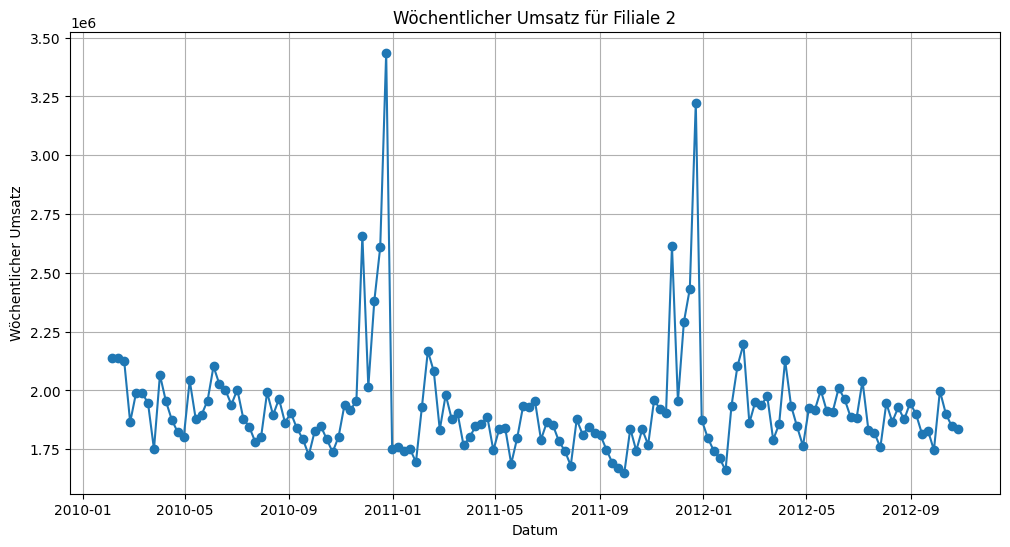

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(sales, marker='o', linestyle='-')
plt.title('Wöchentlicher Umsatz für Filiale {}'.format(store_number))
plt.xlabel('Datum')
plt.ylabel('Wöchentlicher Umsatz')
plt.grid(True)
plt.show()

Seasonal

In [17]:
#seasonal_plot(sales)
#seasonal_subseries_plot(sales)
#acf_plot(sales)
#lag_plot(sales)
#decompose(sales)

Modell wählen

In [18]:
#model_type = 'SARIMA'
model_type = 'Naive'

Residuen und Fitted Values berechnen

In [19]:
if model_type == 'Naive':
    resid, fitted_values = build_naive_model(sales)

if model_type == 'SARIMA':
    sarima_params  = optimal_orders_5.get(str(store_number))
    order = tuple(sarima_params["order"])
    seasonal_order = tuple(sarima_params["seasonal_order"])

    sarima_model = build_SARIMA(sales, order = order, seasonal_order = seasonal_order)
    resid = sarima_model.resid.iloc[1:]
    fitted_values = sarima_model.fittedvalues.iloc[1:]
    sarima_model.summary()

Plot

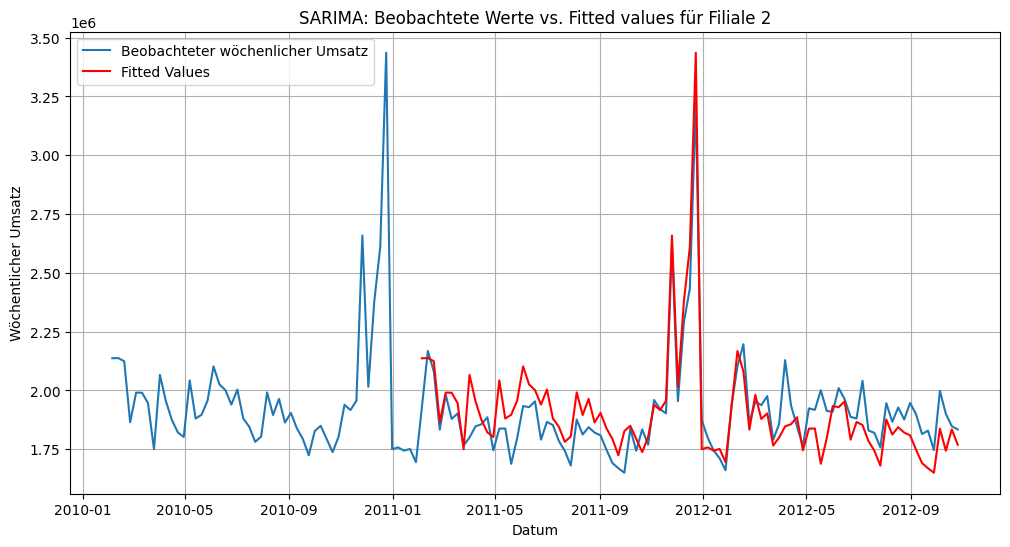

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(sales, label='Beobachteter wöchenlicher Umsatz')
plt.plot(fitted_values, color='red', label='Fitted Values')
plt.title('SARIMA: Beobachtete Werte vs. Fitted values für Filiale {}'.format(store_number))
plt.xlabel('Datum')
plt.ylabel('Wöchentlicher Umsatz')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
pd.set_option('display.max_rows', None)
non_nan_count = resid.count()
print(non_nan_count)
print(resid)

91
date
2011-02-04   -207643.23
2011-02-11     30232.11
2011-02-18    -43566.72
2011-02-25    -31586.19
2011-03-04     -9405.35
2011-03-11   -111376.47
2011-03-18    -43513.22
2011-03-25     15964.24
2011-04-01   -266016.36
2011-04-08   -107136.60
2011-04-15    -18490.10
2011-04-22     64348.67
2011-04-29    -56905.01
2011-05-06   -204838.11
2011-05-13    -42239.29
2011-05-20   -208655.24
2011-05-27   -159381.33
2011-06-03   -168783.72
2011-06-10    -96385.60
2011-06-17    -47864.97
2011-06-24   -149001.29
2011-07-01   -137697.64
2011-07-08    -27740.63
2011-07-15    -60692.50
2011-07-22    -37901.30
2011-07-29   -123553.10
2011-08-05   -115205.72
2011-08-12    -82832.79
2011-08-19   -120240.64
2011-08-26    -42700.58
2011-09-02    -95488.39
2011-09-09    -91128.18
2011-09-16   -102464.08
2011-09-23    -55257.44
2011-09-30   -177045.99
2011-10-07    -12368.01
2011-10-14    -50473.30
2011-10-21     96732.61
2011-10-28    -33458.86
2011-11-04     20646.49
2011-11-11      3912.41
2011-11-

Korrelations Tests

Box Pierce Test: 0.0000
Ljung Box Test: 0.0000
Monti Test: 0.0000
Fisher Test: 0.0000
Fisher Test: 0.0016
Pena Rodriguez (m=29, N=1000): 0.0010
Breusch Godfrey: 0.0000
Run Test: 0.0000
Durbin Watson: 0.9198


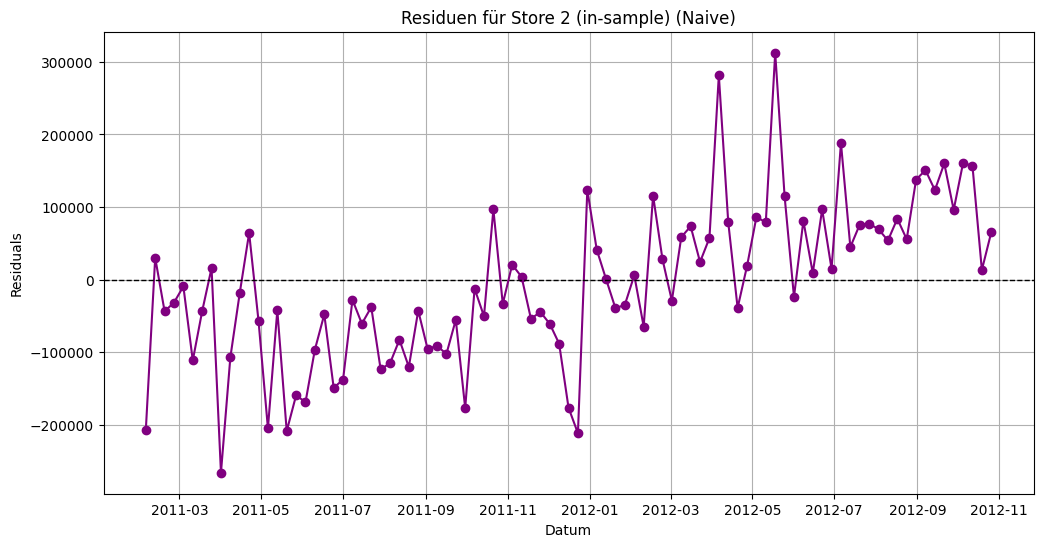

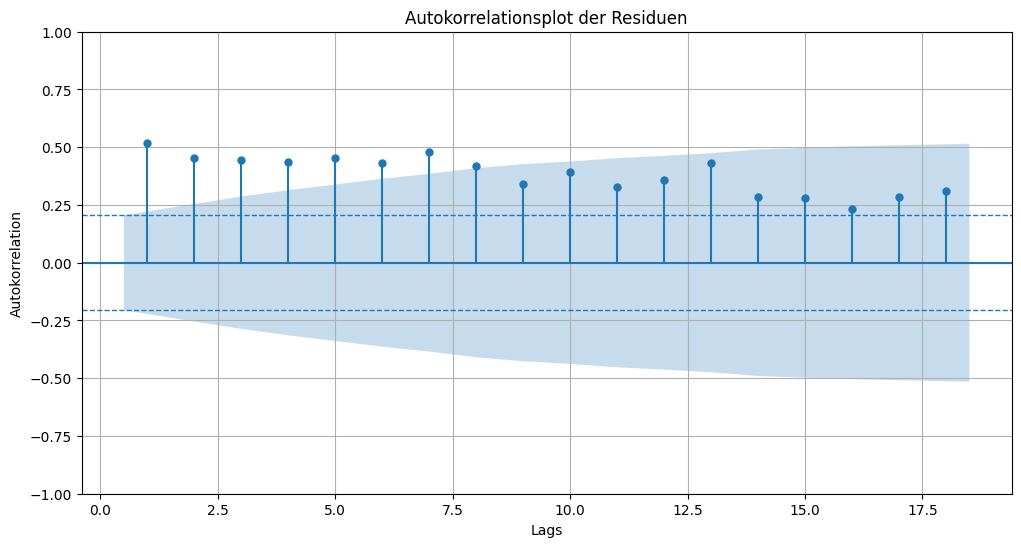

In [22]:
box_pierce_test(residuals = resid, store_num = store_number, model = model_type, lags = 29)
ljung_box_test(residuals = resid, store_num = store_number, model = model_type, lags = 29)
monti_test(residuals = resid, store_num = store_number, model = model_type, m = 29)
fisher_test(residuals = resid, store_num = store_number, model = model_type, version = "acf", m = 29)
fisher_test(residuals = resid, store_num = store_number, model = model_type, version = "pacf", m = 29)
pena_rodriguez_test_mc(residuals = resid)


if model_type == 'SARIMA':
    breusch_godfrey_test(model = sarima_model, lags = 29)
if model_type == 'Naive':
    breusch_godfrey_test_naive(sales, lags = 5)

run_test(residuals = resid)
durbin_watson_test(residuals = resid)

#Residuen Plot
plt.figure(figsize=(12, 6))
plt.plot(resid, marker='o', linestyle='-', color='purple')
plt.title('Residuen für Store {} (in-sample) ({})'.format(store_number, model_type))
plt.xlabel('Datum')
plt.ylabel('Residuals')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.grid(True)
plt.show()

#ACF Plot
acf_resid_plot(resid, lags = 18, print_results = True)



Mittelwert Tests

In [23]:
print(f"Mittelwert der Residuen: {resid.mean():.4f}")


t_test(resid)
wilcoxon_test(resid)
binomial_test(resid)
kolmogorov_test(resid)



Mittelwert der Residuen: -6109.2062
T-Test: 0.5930
Wilcoxon Test: 0.5986
Binomial Test: 0.8341
Kolmogorov Test: 0.6848


(0.07329552997146227, 0.6848023675543344)

SMAPE

In [24]:
numerator = np.abs(fitted_values - sales.iloc[1:])
denominator = (np.abs(fitted_values) + np.abs(sales.iloc[1:])) / 2
smape = np.where(denominator == 0, 0, numerator / denominator)
smape = np.mean(smape) * 100
print(f"SMAPE: {smape:.2f}%")

SMAPE: nan%


Kreuz Validierung

Seasonal Naive Model Cross-Validation RMSE (period=52): 104615.36896683885


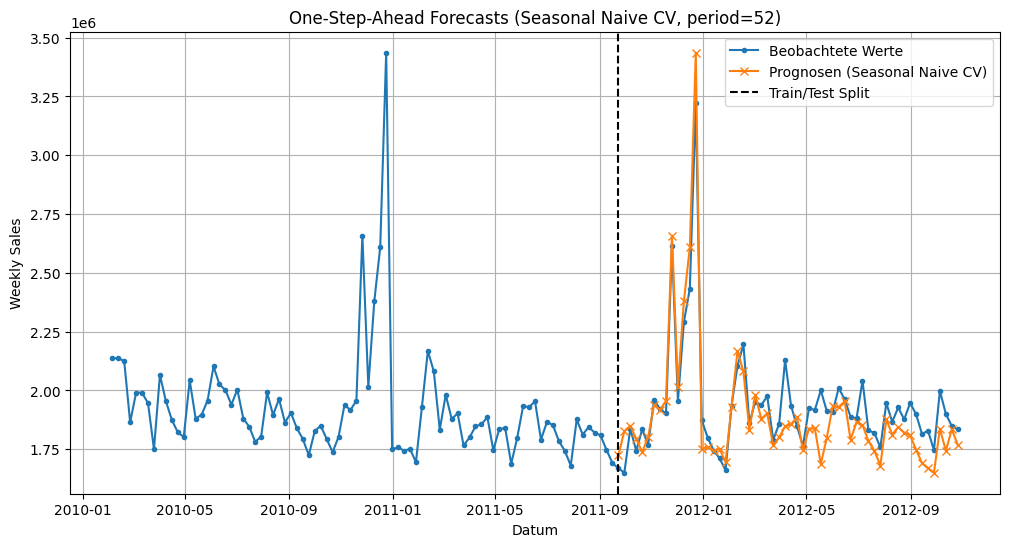

In [25]:
if model_type == 'SARIMA':
    cv_df, train_size = cross_validation_SARIMA(sales, order = order, seasonal_order = seasonal_order)
if model_type == 'Naive':
    cv_df = cross_validation_naive(sales)



Korrelations Tests

58
Box Pierce Test: 0.0000
Ljung Box Test: 0.0000
Monti Test: 0.0034
Fisher Test: 0.0023
Fisher Test: 0.1937
Pena Rodriguez (m=29, N=1000): 0.0360
Breusch Godfrey: 0.0000
Run Test: 0.0086
Durbin Watson: 0.9983


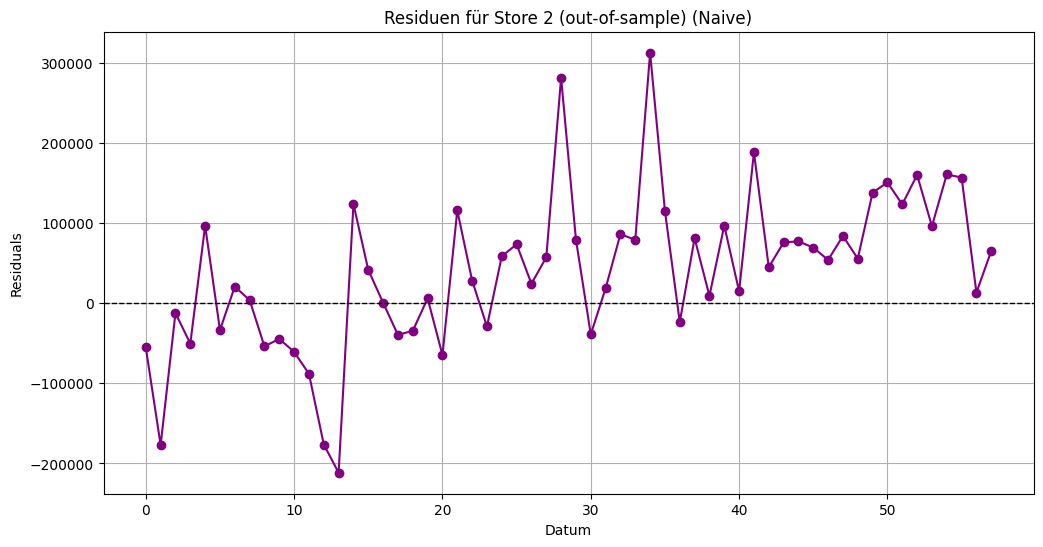

TypeError: acf_resid_plot() missing 2 required positional arguments: 'lags' and 'print_results'

In [26]:
errors = cv_df['error']
print(len(errors))


box_pierce_test(residuals = errors, store_num = store_number, model = model_type, lags = 29)
ljung_box_test(residuals = errors, store_num = store_number, model = model_type, lags = 29)
monti_test(residuals = errors, store_num = store_number, model = model_type, m = 21)
fisher_test(residuals = errors, store_num = store_number, model = model_type, version = "acf", m = 21)
fisher_test(residuals = errors, store_num = store_number, model = model_type, version = "pacf", m = 21)
pena_rodriguez_test_mc(residuals = errors)


if model_type == 'SARIMA':
    breusch_godfrey_test(model = sarima_model, lags = 29) #TODO: Gleich wie in-sample?
if model_type == 'Naive':
    breusch_godfrey_test_naive(sales, lags = 5)


run_test(residuals = errors)

durbin_watson_test(residuals = errors)

#Residuen Plot
plt.figure(figsize=(12, 6))
plt.plot(errors, marker='o', linestyle='-', color='purple')
plt.title('Residuen für Store {} (out-of-sample) ({})'.format(store_number, model_type))
plt.xlabel('Datum')
plt.ylabel('Residuals')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.grid(True)
plt.show()


acf_resid_plot(residuals = errors)


Mittelwert Tests

In [ ]:
print(f'Mittelwert der Errors: {errors.mean()}')

t_test(errors)
wilcoxon_test(errors)
binomial_test(errors)
kolmogorov_test(errors)

hist_plot(errors)


Mittelwert der Errors: 1386.3134728424805
T-Test: 0.9261
Wilcoxon Test: 0.6618
Binomial Test: 0.5118
Kolmogorov Test: 0.7105


NameError: name 'hist_plot' is not defined

SMAPE

In [ ]:
actual_values = cv_df['actual']
forecast_values = cv_df['forecast']

numerator = np.abs(forecast_values - actual_values)
denominator = (np.abs(forecast_values) + np.abs(actual_values)) / 2
smape = np.where(denominator == 0, 0, numerator / denominator)
smape = np.mean(smape) * 100
print(f"SMAPE: {smape:.2f}%")

SMAPE: 4.83%
